In this project I have used IBM employee attrition data to analyse the impact of various features causing employees to quit their job and then use different ML models to predict if an employee is going to resign or not.
Data used can be downloaded from https://www.kaggle.com/pavansubhasht/ibm-hr-analytics-attrition-dataset

In [367]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
np.random.seed(100)

In [368]:
file_path = "/content/WA_Fn-UseC_-HR-Employee-Attrition.csv"

In [369]:
emp_data_org = pd.read_csv(file_path)

In [370]:
print('Dataset dimension: {} rows, {} columns'.format(emp_data_org.shape[0], emp_data_org.shape[1]))

Dataset dimension: 1470 rows, 35 columns


## Understanding the data

In [371]:
emp_data_org.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1470 entries, 0 to 1469
Data columns (total 35 columns):
 #   Column                    Non-Null Count  Dtype 
---  ------                    --------------  ----- 
 0   Age                       1470 non-null   int64 
 1   Attrition                 1470 non-null   object
 2   BusinessTravel            1470 non-null   object
 3   DailyRate                 1470 non-null   int64 
 4   Department                1470 non-null   object
 5   DistanceFromHome          1470 non-null   int64 
 6   Education                 1470 non-null   int64 
 7   EducationField            1470 non-null   object
 8   EmployeeCount             1470 non-null   int64 
 9   EmployeeNumber            1470 non-null   int64 
 10  EnvironmentSatisfaction   1470 non-null   int64 
 11  Gender                    1470 non-null   object
 12  HourlyRate                1470 non-null   int64 
 13  JobInvolvement            1470 non-null   int64 
 14  JobLevel                

In [372]:
emp_data_org.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2


**Observations**
1. There are 1470 data samples, each sample has 35 features including target variable "Attrition".
2. Data contains values of integer types and object(string) types.
3. There are no missing values in any column.

In [373]:
emp_data_org.describe()

,Age,DailyRate,DistanceFromHome,Education,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,HourlyRate,JobInvolvement,JobLevel,JobSatisfaction,MonthlyIncome,MonthlyRate,NumCompaniesWorked,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager
count,1470.000000,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.0,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000,1470.000000
mean,36.923810,802.485714,9.192517,2.912925,1.0,1024.865306,2.721769,65.891156,2.729932,2.063946,2.728571,6502.931293,14313.103401,2.693197,15.209524,3.153741,2.712245,80.0,0.793878,11.279592,2.799320,2.761224,7.008163,4.229252,2.187755,4.123129
std,9.135373,403.509100,8.106864,1.024165,0.0,602.024335,1.093082,20.329428,0.711561,1.106940,1.102846,4707.956783,7117.786044,2.498009,3.659938,0.360824,1.081209,0.0,0.852077,7.780782,1.289271,0.706476,6.126525,3.623137,3.222430,3.568136
min,18.000000,102.000000,1.000000,1.000000,1.0,1.000000,1.000000,30.000000,1.000000,1.000000,1.000000,1009.000000,2094.000000,0.000000,11.000000,3.000000,1.000000,80.0,0.000000,0.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000
25%,30.000000,465.000000,2.000000,2.000000,1.0,491.250000,2.000000,48.000000,2.000000,1.000000,2.000000,2911.000000,8047.000000,1.000000,12.000000,3.000000,2.000000,80.0,0.000000,6.000000,2.000000,2.000000,3.000000,2.000000,0.000000,2.000000
50%,36.000000,802.000000,7.000000,3.000000,1.0,1020.500000,3.000000,66.000000,3.000000,2.000000,3.000000,4919.000000,14235.500000,2.000000,14.000000,3.000000,3.000000,80.0,1.000000,10.000000,3.000000,3.000000,5.000000,3.000000,1.000000,3.000000
75%,43.000000,1157.000000,14.000000,4.000000,1.0,1555.750000,4.000000,83.750000,3.000000,3.000000,4.000000,8379.000000,20461.500000,4.000000,18.000000,3.000000,4.000000,80.0,1.000000,15.000000,3.000000,3.000000,9.000000,7.000000,3.000000,7.000000
max,60.000000,1499.000000,29.000000,5.000000,1.0,2068.000000,4.000000,100.000000,4.000000,5.000000,4.000000,19999.000000,26999.000000,9.000000,25.000000,4.000000,4.000000,80.0,3.000000,40.000000,6.000000,4.000000,40.000000,18.000000,15.000000,17.000000


In [374]:
#counting unique values for each feature

col_name = []
unique_vals = []
data_type = []

for col in emp_data_org.columns.values: # for each column
  unique_entries = pd.unique(emp_data_org[col]) # unique elements in a column
  unique_vals.append(len(unique_entries))
  data_type.append(emp_data_org[col].dtype)

pd.DataFrame({"Column name":emp_data_org.columns, "Unique values count":unique_vals, "Data Type":data_type})

,Column name,Unique values count,Data Type
0,Age,43,int64
1,Attrition,2,object
2,BusinessTravel,3,object
3,DailyRate,886,int64
4,Department,3,object
5,DistanceFromHome,29,int64
6,Education,5,int64
7,EducationField,6,object
8,EmployeeCount,1,int64
9,EmployeeNumber,1470,int64


**Observations:**

1. All the object type entries have few unique values, so these are baiscally categorical data.
2. "Employee Number" has 1470 unique values, one for each employee. It does not help in predicting attrition, this can be removed.
3. "EmployeeCount", "Standardhours" and "Over18" has only one unique value i.e. this feature is same for each employee, does not help in prediction, will be removed.
4. Some intger type data is also categorical type i.e. Education, EnvironmentSatisfaction, JobInvolvement, JobLevel, JobSatisfaction, PerformanceRating, RelationshipSatisfaction, WorkLifeBalance, StockOptionLevel.


**Attrition Target Variable Distribution**

     Attrition  frequency_percent
No        1233              83.88
Yes        237              16.12


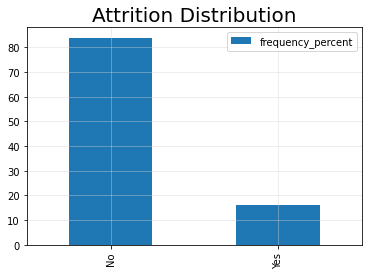

In [375]:
attrition_freq = emp_data_org[['Attrition']].apply(lambda x: x.value_counts())
attrition_freq['frequency_percent'] = round((100 * attrition_freq / attrition_freq.sum()),2)

print(attrition_freq)

# Attrition distribution bar plot
plot = attrition_freq[['frequency_percent']].plot(kind="bar");
plot.set_title("Attrition Distribution", fontsize=20);
plot.grid(color='lightgray', alpha=0.5);

**Observations**
1. Data is highly imbalanced towards one of the target class.
2. Such a data imbalance can cause our ML models to be biased towards the majority class.
2. I will try to use oversampling technique SMOTE to handle this imabalnce.

##Exploratory Data Analysis

###Visualize & understand how different categorical features are behaving against attrition indicator

In [376]:
emp_viz_df = emp_data_org.copy() 

#Adding 2 features for EDA: Employee left and not left
emp_viz_df['Attrition_Yes'] = emp_viz_df['Attrition'].map({'Yes':1, 'No':0}) # 1 means Employee Left
emp_viz_df['Attrition_No'] = emp_viz_df['Attrition'].map({'Yes':0, 'No':1}) # 1 means Employee didnt leave

# Let's look into the new dataset and identify features for which plots needs to be build for categorical features
emp_viz_df.head()

,Age,Attrition,BusinessTravel,DailyRate,Department,DistanceFromHome,Education,EducationField,EmployeeCount,EmployeeNumber,EnvironmentSatisfaction,Gender,HourlyRate,JobInvolvement,JobLevel,JobRole,JobSatisfaction,MaritalStatus,MonthlyIncome,MonthlyRate,NumCompaniesWorked,Over18,OverTime,PercentSalaryHike,PerformanceRating,RelationshipSatisfaction,StandardHours,StockOptionLevel,TotalWorkingYears,TrainingTimesLastYear,WorkLifeBalance,YearsAtCompany,YearsInCurrentRole,YearsSinceLastPromotion,YearsWithCurrManager,Attrition_Yes,Attrition_No
0,41,Yes,Travel_Rarely,1102,Sales,1,2,Life Sciences,1,1,2,Female,94,3,2,Sales Executive,4,Single,5993,19479,8,Y,Yes,11,3,1,80,0,8,0,1,6,4,0,5,1,0
1,49,No,Travel_Frequently,279,Research & Development,8,1,Life Sciences,1,2,3,Male,61,2,2,Research Scientist,2,Married,5130,24907,1,Y,No,23,4,4,80,1,10,3,3,10,7,1,7,0,1
2,37,Yes,Travel_Rarely,1373,Research & Development,2,2,Other,1,4,4,Male,92,2,1,Laboratory Technician,3,Single,2090,2396,6,Y,Yes,15,3,2,80,0,7,3,3,0,0,0,0,1,0
3,33,No,Travel_Frequently,1392,Research & Development,3,4,Life Sciences,1,5,4,Female,56,3,1,Research Scientist,3,Married,2909,23159,1,Y,Yes,11,3,3,80,0,8,3,3,8,7,3,0,0,1
4,27,No,Travel_Rarely,591,Research & Development,2,1,Medical,1,7,1,Male,40,3,1,Laboratory Technician,2,Married,3468,16632,9,Y,No,12,3,4,80,1,6,3,3,2,2,2,2,0,1


In [377]:
cat_col_names = emp_viz_df.select_dtypes(include=[np.object]).columns.tolist() # Get categorical feature names
cat_col_names

['Attrition',
 'BusinessTravel',
 'Department',
 'EducationField',
 'Gender',
 'JobRole',
 'MaritalStatus',
 'Over18',
 'OverTime']

In [378]:
def generate_frequency_graph(col_name):
    
    # Plotting of Employee Attrition against feature
    temp_grp = emp_viz_df.groupby(col_name).agg('sum')[['Attrition_Yes', 'Attrition_No']]
    temp_grp['Percentage Attrition'] =  temp_grp['Attrition_Yes'] / (temp_grp['Attrition_Yes'] + temp_grp['Attrition_No']) * 100
    print(temp_grp)
    emp_viz_df.groupby(col_name).agg('sum')[['Attrition_Yes', 'Attrition_No']].plot(kind='bar', stacked=False, color=['red', 'green'])
    plt.xlabel(col_name)
    plt.ylabel('Attrition');


                   Attrition_Yes  Attrition_No  Percentage Attrition
BusinessTravel                                                      
Non-Travel                    12           138              8.000000
Travel_Frequently             69           208             24.909747
Travel_Rarely                156           887             14.956855


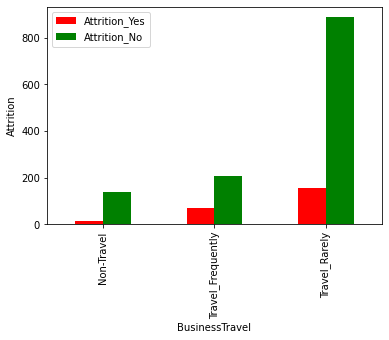

In [379]:
# Plotting of Employee Attrition against Business Travel feature
generate_frequency_graph('BusinessTravel')

Employee attrition precentage is the highest for employees who travel_frequently followed by travel_rarely and non_travel

                        Attrition_Yes  Attrition_No  Percentage Attrition
Department                                                               
Human Resources                    12            51             19.047619
Research & Development            133           828             13.839750
Sales                              92           354             20.627803


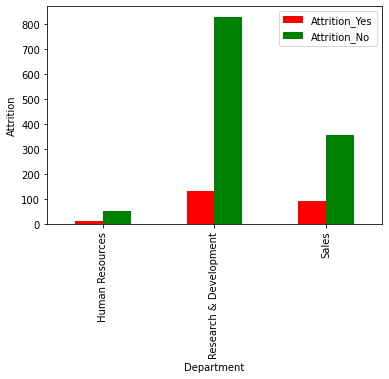

In [380]:
# Plotting of Employee Attrition against Department feature
generate_frequency_graph('Department')

Attrition is highest for Sales department, followed by HR and R&D.

                  Attrition_Yes  Attrition_No  Percentage Attrition
EducationField                                                     
Human Resources               7            20             25.925926
Life Sciences                89           517             14.686469
Marketing                    35           124             22.012579
Medical                      63           401             13.577586
Other                        11            71             13.414634
Technical Degree             32           100             24.242424


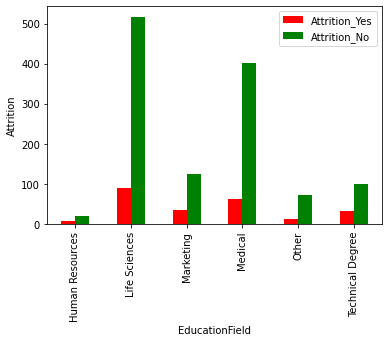

In [381]:
# Plotting of Employee Attrition against EducationField  feature
generate_frequency_graph('EducationField')

Employees who studied HR and employees with technical degree have highest attrition.

        Attrition_Yes  Attrition_No  Percentage Attrition
Gender                                                   
Female             87           501             14.795918
Male              150           732             17.006803


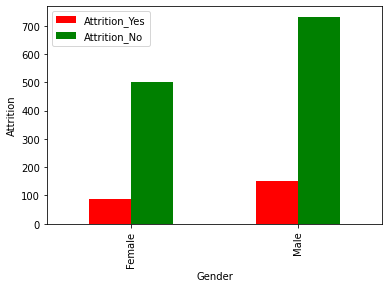

In [382]:
# Plotting of Employee Attrition against Gender feature
generate_frequency_graph('Gender')

Attrition is higher for Male employees compared to Females.

                           Attrition_Yes  Attrition_No  Percentage Attrition
JobRole                                                                     
Healthcare Representative              9           122              6.870229
Human Resources                       12            40             23.076923
Laboratory Technician                 62           197             23.938224
Manager                                5            97              4.901961
Manufacturing Director                10           135              6.896552
Research Director                      2            78              2.500000
Research Scientist                    47           245             16.095890
Sales Executive                       57           269             17.484663
Sales Representative                  33            50             39.759036


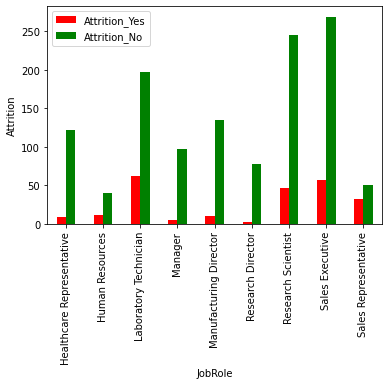

In [383]:
# Plotting of Employee Attrition against MaritalStatus feature
generate_frequency_graph('JobRole')

Sales Representative employees have highest percentage of attrition.

               Attrition_Yes  Attrition_No  Percentage Attrition
MaritalStatus                                                   
Divorced                  33           294             10.091743
Married                   84           589             12.481426
Single                   120           350             25.531915


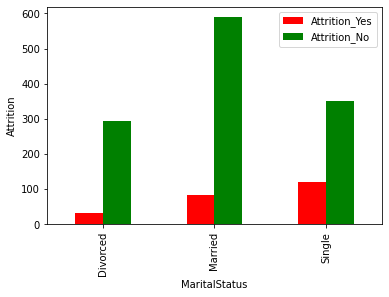

In [384]:
# Plotting of Employee Attrition against MaritalStatus feature
generate_frequency_graph('MaritalStatus')

Single employees have highest attrition, then married and then divorced.

          Attrition_Yes  Attrition_No  Percentage Attrition
OverTime                                                   
No                  110           944             10.436433
Yes                 127           289             30.528846


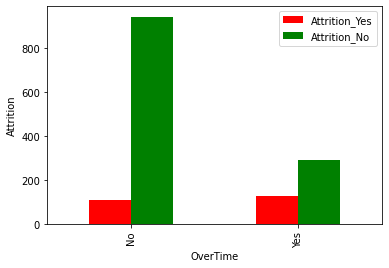

In [385]:
# Plotting of Employee Attrition against MaritalStatus feature
generate_frequency_graph('OverTime')

Attrition is higher for employees who do over time.

### Visualization & understanding how different ordered categorical features are behaving against attrition indicator i.e. Education, EnvironmentSatisfaction, JobInvolvement, JobLevel, JobSatisfaction, PerformanceRating, RelationshipSatisfaction, WorkLifeBalance, StockOptionLevel.

           Attrition_Yes  Attrition_No  Percentage Attrition
Education                                                   
1                     31           139             18.235294
2                     44           238             15.602837
3                     99           473             17.307692
4                     58           340             14.572864
5                      5            43             10.416667


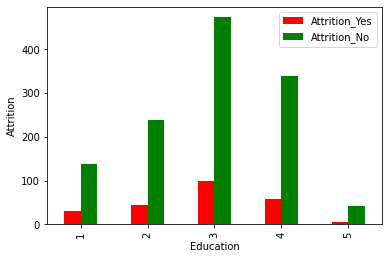

In [386]:
# Plotting of Employee Attrition against Education feature
generate_frequency_graph('Education')

Attrition is highest for low Education level(1) and lowest for high Education level(5).

                 Attrition_Yes  Attrition_No  Percentage Attrition
JobSatisfaction                                                   
1                           66           223             22.837370
2                           46           234             16.428571
3                           73           369             16.515837
4                           52           407             11.328976


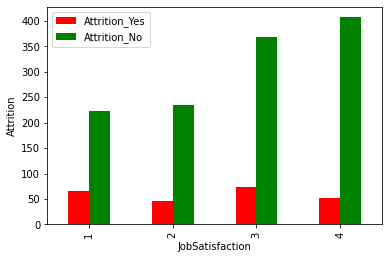

In [387]:
# Plotting of Employee Attrition against JobSatisfaction feature
generate_frequency_graph('JobSatisfaction')

Low job satisfaction corresponds to high attrition and high job satisfaction corresponds to low attrition.

                 Attrition_Yes  Attrition_No  Percentage Attrition
WorkLifeBalance                                                   
1                           25            55             31.250000
2                           58           286             16.860465
3                          127           766             14.221725
4                           27           126             17.647059


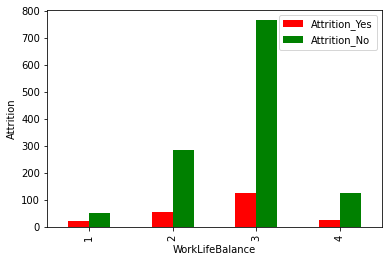

In [388]:
# Plotting of Employee Attrition against WorkLifeBalance feature
generate_frequency_graph('WorkLifeBalance')

Low WorkLifeBalance corresponds to high attrition and vice versa.

Similar inference can be drawn for other features as well, it gives us some insight into importance of features in predicting attrition.

### Exploratory Data Analysis - Numerical Features

Visualizing data distribution of numerical features. Usually, prediction model works well if the data distribution is normal distribution. So, if there are skewed data distirubtion then we can make them normal distribution through log transformations.

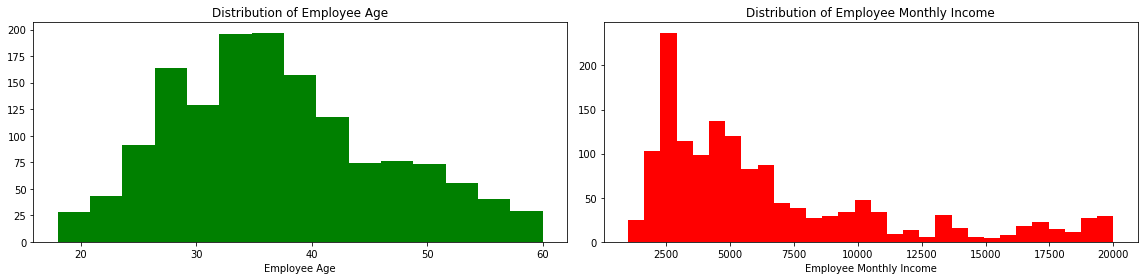

In [389]:
fig = plt.figure(figsize=(16,4))

# Histogram Plot for Employee Age
plt.subplot(1,2,1)
plt.hist(emp_viz_df['Age'], bins=15, color='green')
plt.title('Distribution of Employee Age')
plt.xlabel("Employee Age")

# Histogram Plot for employee Monthly Income
plt.subplot(1,2,2)
plt.hist(emp_viz_df['MonthlyIncome'], bins=30, color='red')
plt.title('Distribution of Employee Monthly Income')
plt.xlabel("Employee Monthly Income")

fig.tight_layout()

In [390]:
print('Skewness in employee Age feature: ', emp_viz_df['Age'].skew())
print('Skewness in employee Monthly Income feature: ', emp_viz_df['MonthlyIncome'].skew())

Skewness in employee Age feature:  0.4132863018563338
Skewness in employee Monthly Income feature:  1.3698166808390662


Observation:
1. Employee Age is not much skewed.
2. Employee Monthly Income is right skewed.

We will apply log transformation on both these features and then see how the graph of distribution after transformation changes.

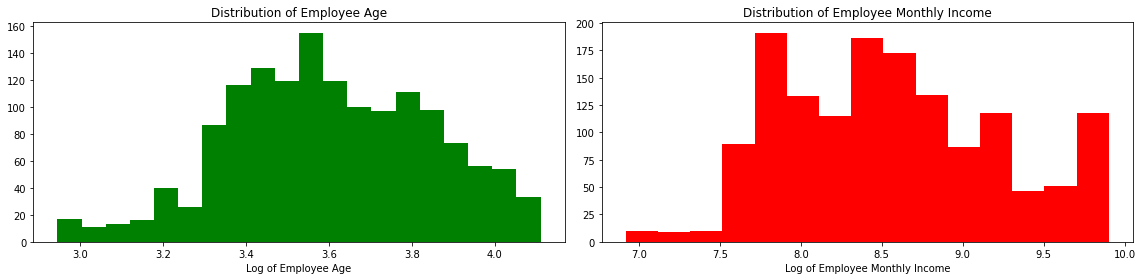

In [391]:
fig = plt.figure(figsize=(16,4))

# Histogram Plot for Employee Age
plt.subplot(1,2,1)
plt.hist(np.log1p(emp_viz_df['Age']), bins=20, color='green')
plt.title('Distribution of Employee Age')
plt.xlabel("Log of Employee Age")

# Histogram Plot for employee Monthly Income
plt.subplot(1,2,2)
plt.hist(np.log1p(emp_viz_df['MonthlyIncome']), bins=15, color='red')
plt.title('Distribution of Employee Monthly Income')
plt.xlabel("Log of Employee Monthly Income")

fig.tight_layout()


*We can observe above that without log transformation, "Age" feature   looks normally distributed more than "MonthlyIncome" feature.  

Hence, after log transformation, there is hardly any change in "Age" distributions but there is significant transformation in "MonthlyIncome" feature.  

This can also be confirmed by checking the skewness of each feature by applying numpy skew metric and higher the skewness, higher the value.  

So, we will use some threshold value of skewness to carry out log transformation on features with high skewness.



###Feature Engineering

Feature engineering is one aspect which provided a huge impact on the outcome rather than the model. Here, we try creating new features with the existing variables we have based on following assumptions.




Addition of New Features

1. Tenure per job: Usually, people who have worked with many companies but for small periods at every organization tend to leave early as they always need a change of Organization to keep them going.
    
2. Years without Change: For any person, a change either in role or job level or responsibility is needed to keep the work exciting to continue. We create a variable to see how many years it has been for an employee without any sort of change using Promotion, Role and Job Change as a metric to cover different variants of change.

3. Compensation Ratio: Compa Ratio is the ratio of the actual pay of an Employee to the midpoint of a salary range. The salary range can be that of his/her department or organization or role. The benchmark numbers can be a organization’s pay or Industry average.

In [392]:
emp_proc_df = emp_data_org.copy() # Copy cleaned dataset for feature engineering

emp_proc_df['TenurePerJob'] = 0

for i in range(0, len(emp_proc_df)):
    if emp_proc_df.loc[i,'NumCompaniesWorked'] > 0:
        emp_proc_df.loc[i,'TenurePerJob'] = emp_proc_df.loc[i,'TotalWorkingYears'] / emp_proc_df.loc[i,'NumCompaniesWorked']

emp_proc_df['YearWithoutChange1'] = emp_proc_df['YearsInCurrentRole'] - emp_proc_df['YearsSinceLastPromotion']
emp_proc_df['YearWithoutChange2'] = emp_proc_df['TotalWorkingYears'] - emp_proc_df['YearsSinceLastPromotion']

monthly_income_median = np.median(emp_proc_df['MonthlyIncome'])
emp_proc_df['CompRatioOverall'] = emp_proc_df['MonthlyIncome'] / monthly_income_median

print('Dataset dimension: {} rows, {} columns'.format(emp_proc_df.shape[0], emp_proc_df.shape[1]))

Dataset dimension: 1470 rows, 39 columns


Removing unncecessary features

In [393]:
feat_to_remove = ['EmployeeNumber', 'EmployeeCount', 'Over18', 'StandardHours']
emp_proc_df.drop( feat_to_remove , axis = 1, inplace = True )
print('Dataset dimension: {} rows, {} columns'.format(emp_proc_df.shape[0], emp_proc_df.shape[1]))

Dataset dimension: 1470 rows, 35 columns


In [394]:
# separating features according to their types, as different processing will be employed on these

full_col_names = emp_proc_df.columns.tolist()
categorical_obj_features = emp_proc_df.select_dtypes(include=[np.object]).columns.tolist()
target = ['Attrition']
categorical_obj_features = set(categorical_obj_features) - set(target)

num_features = emp_proc_df.select_dtypes(include=[np.int64,np.float64]).columns.tolist()
num_discrete_features = [col for col in num_features if len(emp_proc_df[col].unique())<=5]

num_continuous_features = set(num_features)-set(num_discrete_features)


In [395]:
cat_emp_df = emp_proc_df[categorical_obj_features]
num_emp_discrete_df = emp_proc_df[num_discrete_features]
num_emp_continuous_df = emp_proc_df[num_continuous_features]
target_df = emp_proc_df[target]

**Transforming Numerical Features**

In order to fix the skewness, let’s take the log for all numerical features with an absolute skew greater than 80% (Note: log+1, to avoid division by zero issues

In [396]:
for col in num_continuous_features:
    if num_emp_continuous_df[col].skew() > 0.80:
        num_emp_continuous_df[col] = np.log1p(num_emp_continuous_df[col])

num_emp_continuous_df.head()

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  This is separate from the ipykernel package so we can avoid doing imports until


,NumCompaniesWorked,MonthlyRate,TrainingTimesLastYear,DistanceFromHome,MonthlyIncome,Age,CompRatioOverall,YearsAtCompany,YearsSinceLastPromotion,TenurePerJob,YearWithoutChange2,YearsInCurrentRole,PercentSalaryHike,DailyRate,YearWithoutChange1,YearsWithCurrManager,HourlyRate,TotalWorkingYears
0,2.197225,19479,0,0.693147,8.698514,41,0.796758,1.945910,0.000000,0.693147,2.197225,1.609438,2.484907,1102,4,1.791759,94,2.197225
1,0.693147,24907,3,2.197225,8.543056,49,0.714368,2.397895,0.693147,2.397895,2.302585,2.079442,3.178054,279,6,2.079442,61,2.397895
2,1.945910,2396,3,1.098612,7.645398,37,0.354090,0.000000,0.000000,0.773190,2.079442,0.000000,2.772589,1373,0,0.000000,92,2.079442
3,0.693147,23159,3,1.386294,7.975908,33,0.464602,2.197225,1.386294,2.197225,1.791759,2.079442,2.484907,1392,4,0.000000,56,2.197225
4,2.302585,16632,3,1.098612,8.151622,27,0.533578,1.098612,1.098612,0.510826,1.609438,1.098612,2.564949,591,0,1.098612,40,1.945910


**Transforming Categorical features into one hot enocded vectors.**


In [397]:
# Let's create dummy variables for each categorical attribute for training our calssification model
for col in categorical_obj_features:
    col_dummies = pd.get_dummies(cat_emp_df[col], prefix=col)
    cat_emp_df = pd.concat([cat_emp_df, col_dummies], axis=1)

# Use the pandas apply method to numerically encode our attrition target variable
attrition_target = emp_proc_df['Attrition'].map({'Yes':1, 'No':0})

# Drop categorical feature for which dummy variables have been created
cat_emp_df.drop(categorical_obj_features, axis=1, inplace=True)

cat_emp_df.head()

,JobRole_Healthcare Representative,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,Gender_Female,Gender_Male,OverTime_No,OverTime_Yes,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,Department_Human Resources,Department_Research & Development,Department_Sales,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely
0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1
1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0
2,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,1,0,0,0,1
3,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0
4,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,1,0,0,0,1


In [398]:
# Concat the three dataframes together columnwise
final_emp_df = pd.concat([num_emp_continuous_df, num_emp_discrete_df, cat_emp_df], axis=1)

print('Dataset dimension after treating categorical features with dummy variables: {} rows, {} columns'.format(final_emp_df.shape[0], final_emp_df.shape[1]))
final_emp_df.head()

Dataset dimension after treating categorical features with dummy variables: 1470 rows, 55 columns


,NumCompaniesWorked,MonthlyRate,TrainingTimesLastYear,DistanceFromHome,MonthlyIncome,Age,CompRatioOverall,YearsAtCompany,YearsSinceLastPromotion,TenurePerJob,YearWithoutChange2,YearsInCurrentRole,PercentSalaryHike,DailyRate,YearWithoutChange1,YearsWithCurrManager,HourlyRate,TotalWorkingYears,Education,EnvironmentSatisfaction,JobInvolvement,JobLevel,JobSatisfaction,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,WorkLifeBalance,JobRole_Healthcare Representative,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,Gender_Female,Gender_Male,OverTime_No,OverTime_Yes,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,Department_Human Resources,Department_Research & Development,Department_Sales,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely
0,2.197225,19479,0,0.693147,8.698514,41,0.796758,1.945910,0.000000,0.693147,2.197225,1.609438,2.484907,1102,4,1.791759,94,2.197225,2,2,3,2,4,3,1,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,1,0,0,1,0,0,1,0,0,1,0,0,1
1,0.693147,24907,3,2.197225,8.543056,49,0.714368,2.397895,0.693147,2.397895,2.302585,2.079442,3.178054,279,6,2.079442,61,2.397895,1,3,2,2,2,4,4,1,3,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,0,1,0,0,1,0
2,1.945910,2396,3,1.098612,7.645398,37,0.354090,0.000000,0.000000,0.773190,2.079442,0.000000,2.772589,1373,0,0.000000,92,2.079442,2,4,2,1,3,3,2,0,3,0,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,1,0,1,0,0,0,1
3,0.693147,23159,3,1.386294,7.975908,33,0.464602,2.197225,1.386294,2.197225,1.791759,2.079442,2.484907,1392,4,0.000000,56,2.197225,4,4,3,1,3,3,3,0,3,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,0,1,0,1,0,0,1,0,0,1,0
4,2.302585,16632,3,1.098612,8.151622,27,0.533578,1.098612,1.098612,0.510826,1.609438,1.098612,2.564949,591,0,1.098612,40,1.945910,1,1,3,1,2,3,4,1,3,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,1,1,0,0,1,0,0,1,0,0,0,1


### Model and evaluation metrics

This is a binary classification problem we can use following Metrics:
1. Accuracy
2. True Positive Rate(recall or sensitivity)
3. Precision 
4. True Negative Rate (specificity)
5. F1 score
6. ROC curve
7. Confusion matrix

Following models will be compared based on above metrics:
1. Logistic Regression
2. Support Vector Classifier
3. Decision Tree Classifier
4. Random Forest Classifier 	
5. Extra Trees Classifier 	
6. 	Gradient Boosting Classifier 	
7. 	Adaptive Boost Classifier 	
8. 	Gaussian Naive Bayes classifier

In [399]:
# since data is hihgly imbalanced so using stratified shuffle split to ensure proportionate samples from each class
from sklearn.model_selection import StratifiedShuffleSplit
from sklearn.model_selection import train_test_split

#train and test set split
split = StratifiedShuffleSplit(n_splits=1, test_size=0.20, random_state=42)
for train_index, test_index in split.split(final_emp_df, target_df["Attrition"]):
  X_train = final_emp_df.loc[train_index]
  X_test = final_emp_df.loc[test_index]
  y_train = attrition_target.loc[train_index]
  y_test = attrition_target.loc[test_index]


#train and validation split
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size = 0.1)


print(len(X_train), "train set,", len(X_test), "test set", len(X_val), "validation set")

1058 train set, 294 test set 118 validation set


In [400]:
X_test.head()

,NumCompaniesWorked,MonthlyRate,TrainingTimesLastYear,DistanceFromHome,MonthlyIncome,Age,CompRatioOverall,YearsAtCompany,YearsSinceLastPromotion,TenurePerJob,YearWithoutChange2,YearsInCurrentRole,PercentSalaryHike,DailyRate,YearWithoutChange1,YearsWithCurrManager,HourlyRate,TotalWorkingYears,Education,EnvironmentSatisfaction,JobInvolvement,JobLevel,JobSatisfaction,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,WorkLifeBalance,JobRole_Healthcare Representative,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,Gender_Female,Gender_Male,OverTime_No,OverTime_Yes,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,Department_Human Resources,Department_Research & Development,Department_Sales,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely
1061,0.693147,7103,2,2.639057,7.617760,24,0.345924,0.693147,0.000000,0.693147,0.693147,0.000000,2.639057,830,0,0.000000,78,0.693147,2,4,3,1,2,3,3,1,3,0,0,0,0,0,0,0,0,1,0,1,0,0,0,0,1,0,1,0,0,1,0,0,0,1,1,0,0
891,0.693147,19982,5,1.098612,7.606885,44,0.342755,2.397895,2.079442,2.397895,1.386294,1.791759,2.639057,1117,-2,2.079442,72,2.397895,1,1,4,1,4,3,4,1,3,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,1,0,1,0,0,1,0,0,1,0,0,0,1
456,2.302585,25291,3,2.079442,9.355133,31,1.208800,1.791759,0.000000,0.747214,2.397895,1.609438,3.091042,688,4,0.693147,44,2.397895,3,3,2,3,4,4,3,1,2,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,1,0,0,0,0,1,0,0,1
922,0.693147,17477,4,1.609438,9.862197,44,1.589480,3.258097,2.708050,3.295837,2.564949,2.302585,2.708050,1199,-5,2.639057,92,3.295837,2,3,4,5,1,3,4,2,2,0,0,0,1,0,0,0,0,0,0,1,0,0,0,0,0,1,1,0,1,0,0,0,1,0,0,0,1
69,0.000000,21777,0,2.302585,8.128290,36,0.523993,0.693147,0.000000,0.000000,1.098612,0.000000,2.890372,318,0,0.000000,79,1.098612,3,4,2,1,3,3,1,1,2,0,0,0,0,0,0,1,0,0,0,0,0,1,0,0,0,1,0,1,0,1,0,0,1,0,0,0,1


In [401]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()
scl = scaler.fit(X_train)
X_train = scl.transform(X_train)
X_val = scl.transform(X_val)
X_test = scl.transform(X_test)
pd.DataFrame(X_test, columns = final_emp_df.columns).head()

,NumCompaniesWorked,MonthlyRate,TrainingTimesLastYear,DistanceFromHome,MonthlyIncome,Age,CompRatioOverall,YearsAtCompany,YearsSinceLastPromotion,TenurePerJob,YearWithoutChange2,YearsInCurrentRole,PercentSalaryHike,DailyRate,YearWithoutChange1,YearsWithCurrManager,HourlyRate,TotalWorkingYears,Education,EnvironmentSatisfaction,JobInvolvement,JobLevel,JobSatisfaction,PerformanceRating,RelationshipSatisfaction,StockOptionLevel,WorkLifeBalance,JobRole_Healthcare Representative,JobRole_Human Resources,JobRole_Laboratory Technician,JobRole_Manager,JobRole_Manufacturing Director,JobRole_Research Director,JobRole_Research Scientist,JobRole_Sales Executive,JobRole_Sales Representative,EducationField_Human Resources,EducationField_Life Sciences,EducationField_Marketing,EducationField_Medical,EducationField_Other,EducationField_Technical Degree,Gender_Female,Gender_Male,OverTime_No,OverTime_Yes,MaritalStatus_Divorced,MaritalStatus_Married,MaritalStatus_Single,Department_Human Resources,Department_Research & Development,Department_Sales,BusinessTravel_Non-Travel,BusinessTravel_Travel_Frequently,BusinessTravel_Travel_Rarely
0,-0.581910,-0.998651,-0.609528,0.772347,-1.438992,-1.424318,-1.210753,-1.522787,-0.963632,-0.829223,-1.779224,-1.773900,-0.570424,0.074062,-0.626945,-1.727321,0.610197,-2.339142,-0.887094,1.176555,0.374419,-0.992590,-0.661975,-0.425210,0.237851,0.234346,0.347946,-0.321298,-0.190365,-0.467861,-0.264135,-0.323085,-0.229644,-0.487265,-0.562068,4.354568,-0.142305,1.206133,-0.366028,-0.659962,-0.229644,-0.33543,1.222818,-1.222818,0.629109,-0.629109,-0.532898,1.082813,-0.683671,-0.203319,-1.341246,1.465882,2.935674,-0.473853,-1.574885
1,-0.581910,0.781738,1.784829,-1.019383,-1.455761,0.770611,-1.219825,0.770673,1.590425,1.134643,-0.871928,0.515954,-0.570424,0.789594,-1.239418,0.884316,0.314823,0.144549,-1.864746,-1.579450,1.784152,-0.992590,1.143102,-0.425210,1.163019,0.234346,0.347946,-0.321298,-0.190365,-0.467861,-0.264135,-0.323085,-0.229644,2.052273,-0.562068,-0.229644,-0.142305,1.206133,-0.366028,-0.659962,-0.229644,-0.33543,1.222818,-1.222818,0.629109,-0.629109,-0.532898,1.082813,-0.683671,-0.203319,0.745575,-0.682183,-0.340637,-0.473853,0.634967
2,1.815701,1.515652,0.188591,0.121444,1.239992,-0.656093,1.258984,-0.044784,-0.963632,-0.766938,0.452209,0.282948,1.532062,-0.279965,0.598000,-0.856775,-1.063587,0.144549,0.090558,0.257887,-1.035315,0.889418,1.143102,2.351779,0.237851,0.234346,-1.046474,-0.321298,-0.190365,-0.467861,3.785939,-0.323085,-0.229644,-0.487265,-0.562068,-0.229644,-0.142305,1.206133,-0.366028,-0.659962,-0.229644,-0.33543,-0.817783,0.817783,0.629109,-0.629109,1.876531,-0.923520,-0.683671,-0.203319,-1.341246,1.465882,-0.340637,-0.473853,0.634967
3,-0.581910,0.435448,0.986710,-0.425229,2.021871,0.770611,2.348575,1.927934,2.362508,2.169069,0.670875,1.168784,-0.249492,0.994032,-2.158127,1.587155,1.299402,1.452783,-0.887094,0.257887,1.784152,2.771426,-1.564514,-0.425210,1.163019,1.403864,-1.046474,-0.321298,-0.190365,-0.467861,3.785939,-0.323085,-0.229644,-0.487265,-0.562068,-0.229644,-0.142305,1.206133,-0.366028,-0.659962,-0.229644,-0.33543,-0.817783,0.817783,0.629109,-0.629109,1.876531,-0.923520,-0.683671,-0.203319,0.745575,-0.682183,-0.340637,-0.473853,0.634967
4,-1.614505,1.029878,-2.205766,0.380987,-0.651767,-0.107361,-0.701080,-1.522787,-0.963632,-1.627727,-1.248489,-1.773900,0.598608,-1.202429,-0.626945,-1.727321,0.659426,-1.748409,0.090558,1.176555,-1.035315,-0.992590,0.240563,-0.425210,-1.612487,0.234346,-1.046474,-0.321298,-0.190365,-0.467861,-0.264135,-0.323085,-0.229644,2.052273,-0.562068,-0.229644,-0.142305,-0.829096,-0.366028,1.515239,-0.229644,-0.33543,-0.817783,0.817783,-1.589549,1.589549,-0.532898,1.082813,-0.683671,-0.203319,0.745575,-0.682183,-0.340637,-0.473853,0.634967


In [402]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier, ExtraTreesClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import SelectFromModel

from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, roc_auc_score, f1_score

In [403]:
def gen_model_performance(actual_target, pred_target):
    model_conf_matrix = confusion_matrix(actual_target, pred_target)
    model_roc_score = roc_auc_score(actual_target, pred_target)
    model_accuracy = accuracy_score(actual_target, pred_target) * 100.0
    
    TP = model_conf_matrix[1][1]; TN = model_conf_matrix[0][0]; 
    FP = model_conf_matrix[0][1]; FN = model_conf_matrix[1][0];
    sensitivity = TP / float(TP + FN) * 100.0; specificity = TN / float(TN + FP) * 100.0;
    precision = TP / float(TP + FP) * 100.0;
    
    return sensitivity, specificity, model_accuracy, precision, model_roc_score

In [404]:
def evaluate_model_score(X_train, y_train, X_val, y_val, scoring='f1'):
    
    logreg_model = LogisticRegression(random_state=0, max_iter = 1000)
    svc_model = SVC()
    rfc_model = RandomForestClassifier(n_estimators=100)
    extrees_model = ExtraTreesClassifier()
    gboost_model = GradientBoostingClassifier()
    dt_model = DecisionTreeClassifier()
    aboost_model = AdaBoostClassifier()
    gnb_model = GaussianNB()
    

    models = [logreg_model, svc_model, dt_model, rfc_model, 
              extrees_model, gboost_model, aboost_model, gnb_model]
    
    model_results = pd.DataFrame(columns = ["Model", "Accuracy", "Precision", 
                                            "Sensitivity","Specificity","ROC Score"])
    
    for model in models:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_val)    
        sensitivity, specificity, accuracy, precision, roc_score = gen_model_performance(y_val, y_pred)
        model_results = model_results.append({"Model": model.__class__.__name__,
                              "Accuracy": accuracy, "Precision": precision,
                              "Sensitivity": sensitivity, "Specificity": specificity,
                              "ROC Score": roc_score}, ignore_index=True)
    return model_results


In [405]:
model_results = evaluate_model_score(X_train, y_train, X_val, y_val)

model_results

,Model,Accuracy,Precision,Sensitivity,Specificity,ROC Score
0,LogisticRegression,87.288136,83.333333,55.555556,96.703297,0.761294
1,SVC,82.203390,87.500000,25.925926,98.901099,0.624135
2,DecisionTreeClassifier,72.033898,37.500000,33.333333,83.516484,0.584249
3,RandomForestClassifier,79.661017,71.428571,18.518519,97.802198,0.581604
4,ExtraTreesClassifier,80.508475,75.000000,22.222222,97.802198,0.600122
5,GradientBoostingClassifier,79.661017,61.538462,29.629630,94.505495,0.620676
6,AdaBoostClassifier,81.355932,72.727273,29.629630,96.703297,0.631665
7,GaussianNB,77.118644,50.000000,74.074074,78.021978,0.760480


### SMOTE to tackle class imabalance

In [406]:
from imblearn.over_sampling import SMOTE

oversampler=SMOTE(random_state=0)
X_train, y_train = oversampler.fit_sample(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [407]:
model_results = evaluate_model_score(X_train, y_train, X_val, y_val)

model_results

,Model,Accuracy,Precision,Sensitivity,Specificity,ROC Score
0,LogisticRegression,77.966102,51.428571,66.666667,81.318681,0.739927
1,SVC,85.593220,75.000000,55.555556,94.505495,0.750305
2,DecisionTreeClassifier,78.813559,54.545455,44.444444,89.010989,0.667277
3,RandomForestClassifier,79.661017,63.636364,25.925926,95.604396,0.607652
4,ExtraTreesClassifier,81.355932,77.777778,25.925926,97.802198,0.618641
5,GradientBoostingClassifier,83.898305,75.000000,44.444444,95.604396,0.700244
6,AdaBoostClassifier,84.745763,73.684211,51.851852,94.505495,0.731787
7,GaussianNB,72.033898,43.478261,74.074074,71.428571,0.727513


##Principal Component Analysis

In [408]:
from sklearn.decomposition import PCA
pca= PCA(n_components=5)
X_train_pca =pca.fit_transform(X_train)
X_val_pca = pca.transform(X_val)
X_test_pca = pca.transform(X_test)

# Explained variance ratio
explained_variance = np.var(compo, axis=0)
evr= explained_variance/np.sum(explained_variance) *100
cevr=np.cumsum(evr)
cevr

array([ 65.16549149, 100.        ])

### Hyperparameter tuning for Random forest using grid search.

In [409]:
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV

# Hyperparameters Tuning for Random Forest
rfc_param_grid = {
                 'max_depth' : [10, 15, 20, 25],
                 'n_estimators': [50, 100, 150, 200],
                 'max_features': ['sqrt', 'auto', 'log2'],
                 }
rfc_best_model = RandomForestClassifier(n_jobs = -1)
rfc_cross_val = StratifiedKFold(n_splits=5)

rfc_grid_search = GridSearchCV(rfc_best_model,
                               scoring='accuracy',
                               param_grid=rfc_param_grid,
                               cv=rfc_cross_val,
                               verbose=1)

rfc_grid_search.fit(X_train_smote, y_train_smote)
rfc_model = rfc_grid_search
rfc_parameters = rfc_grid_search.best_params_



Fitting 5 folds for each of 48 candidates, totalling 240 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done 240 out of 240 | elapsed:  2.4min finished


In [410]:
rfc_parameters
rfc_best_model = RandomForestClassifier(**rfc_parameters)
rfc_best_model = rfc_best_model.fit(X_train, y_train)

Scores on validation set

In [411]:
y_pred = rfc_best_model.predict(X_val)

sensitivity, specificity, model_accuracy, precision, model_roc_score = gen_model_performance(y_val, y_pred)
print("sensitivity", sensitivity)
print("specificity", specificity)
print("accuracy", model_accuracy)
print("precision", precision)
print("roc", model_roc_score)

sensitivity 25.925925925925924
specificity 95.6043956043956
accuracy 79.66101694915254
precision 63.63636363636363
roc 0.6076516076516078


### Test scores of final selected model

In [412]:
y_pred = rfc_best_model.predict(X_test)

sensitivity, specificity, model_accuracy, precision, model_roc_score = gen_model_performance(y_test, y_pred)
print("sensitivity", sensitivity)
print("specificity", specificity)
print("accuracy", model_accuracy)
print("precision", precision)
print("roc", model_roc_score)

sensitivity 27.659574468085108
specificity 96.35627530364373
accuracy 85.37414965986395
precision 59.09090909090909
roc 0.6200792488586442


In [413]:
print("Classification Report: \n {}\n".format(
            classification_report(y_test, y_pred)))
print("Confusion Matrix: \n {}\n".format(
            confusion_matrix(y_test, y_pred)))

Classification Report: 
               precision    recall  f1-score   support

           0       0.88      0.96      0.92       247
           1       0.59      0.28      0.38        47

    accuracy                           0.85       294
   macro avg       0.73      0.62      0.65       294
weighted avg       0.83      0.85      0.83       294


Confusion Matrix: 
 [[238   9]
 [ 34  13]]



Observations:
1. Our model has sensitivity of around 28 percent i.e. out of all the employees going to resign we are able to predict 28% of them, this is significant improvement over no prediction at all.
2. Our model is still biased towards predicting non attrition, maybe better feature engineering and feature selection and better way to handle class imbalance or using some other prediction model might give some improvement.

### Plotting feature importance for the final model

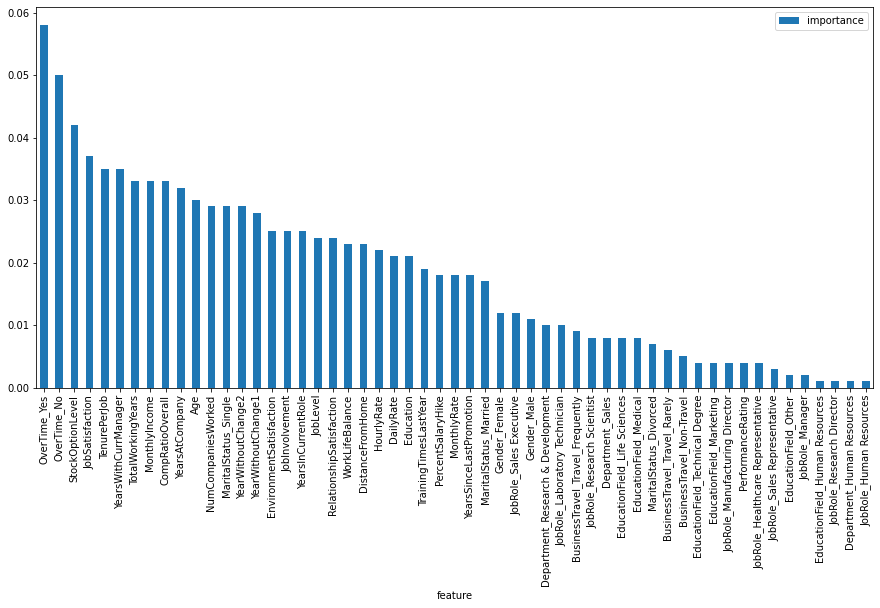

In [414]:
score = np.round(rfc_best_model.feature_importances_, 3)

X_train = pd.DataFrame(X_train, columns = final_emp_df.columns)
X_val = pd.DataFrame(X_val, columns = final_emp_df.columns)
refclasscol = X_train.columns

importances = pd.DataFrame({'feature':refclasscol, 'importance':score})
importances = importances.sort_values('importance', ascending=False).set_index('feature')

importances.plot.bar(figsize = (15,7))

**Observations**
1. From the feature importance we can see that our engineered features i.e. "TenurePerJob", "CompRatioOverall" and "YearsWithoutChange" have higher importance values compared to many of the other given features. Thus it can be concluded that feature engineering was successful.

